### Questo notebook contiene l'implementazione di un Convolutional Neural Network che usa come vettori delle recensioni i token id. Questi vettori vengono addestrati nel layer "Embeddings" di keras col parametro trainable = True

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, MaxPooling1D, Flatten
import pandas as pd
from preprocessing import *
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np

In [2]:
w2v_pretrained = Word2Vec.load("w2vPreTrained") # carica gli embedding pre addestrati

In [3]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 6)
(3150, 6)
(2998, 6)
(2196, 6)


In [4]:
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 412, 0: 206})


In [6]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [7]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, 2)

total number of types extracted is: 1788


In [8]:
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)

In [9]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][2]

['little', 'feature']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)

In [11]:
# this cell generates negative samples

negative_reviews = [] # list of negative reviews
for rev, label in zip(X_train, Y_train):
    if label == 0:
        negative_reviews.append(rev)
    
generated_reviews = generate_samples(negative_reviews, int(len(negative_reviews)/2), w2v_pretrained)

# run this only one time. This extend the train with the artificial reviews
X_train.extend(generated_reviews)
Y_train.extend([0 for x in generated_reviews])

['joke']
-
['laugh']
--------------------------
['price', 'product', 'nice', 'quality', 'nice', 'feature', 'definitely', 'reason', 'give', 'think', 'may', 'buyer', 'error', 'first', 'ignore', 'product', 'plug', 'time', 'work', 'really', 'unlike', 'not_a', 'stand', 'device', 'also', 'speaker', 'not_very', 'loud', 'buy', 'bluetooth', 'speaker', 'sure', 'lot', 'figure', 'use', 'kind', 'seem', 'like', 'device', 'plus', 'set', 'awful', 'would', 'definitely', 'money', 'buy', 'one', 'actually']
-
['cost', 'product', 'decent', 'quality', 'decent', 'feature', 'definitely', 'reason', 'present', 'imagine', 'may', 'buyer', 'error', 'start', 'ignore', 'product', 'plug', 'sentence', 'run', 'truly', 'different', 'not_a', 'base', 'device', 'also', 'speaker', 'not_very', 'loudly', 'purchase', 'bluetooth', 'speaker', 'sure', 'plenty', 'figure', 'utilize', 'kind', 'seem', 'wish', 'device', 'plus', 'adjust', 'terrible', 'would', 'definitely', 'money', 'purchase', 'one', 'really']
-------------------------

In [12]:
t = Tokenizer()
t.fit_on_texts(X_train)
X_train_encoded = t.texts_to_sequences(X_train)
max_length = len(max(bigrams[cleaned_reviews], key = len))
Xtrain = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')

In [13]:
X_test_encoded = t.texts_to_sequences(X_test)
Xtest = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

In [14]:
vocab_size = len(t.word_index) + 1
vocab_size

701

In [15]:
from keras.utils import to_categorical
Y_train_hot = to_categorical(Y_train)
Y_test_hot = to_categorical(Y_test)

In [16]:
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='binary_accuracy', patience=25)

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length, trainable = True))
model.add(Dropout(0.2))
model.add(Conv1D(filters=16, kernel_size=10, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          70100     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 91, 16)            16016     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dropout_1 (Dropout)         (None, 720)               0         
                                                        

In [17]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [18]:
from sklearn.model_selection import KFold

def fit_and_evaluate(model, X, y, epochs=100, val = ()):
    model.fit(X, y,epochs=epochs, batch_size=16, verbose=2, validation_data = val, callbacks = [early_stopping])
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

# Initialize the KFold object
kfold = KFold(n_splits=5, shuffle=True)

# Loop over the folds and fit/evaluate the model
accuracies = []
for train_index, val_index in kfold.split(Xtrain):
    X_train, X_val = Xtrain[train_index], Xtrain[val_index]
    y_train, y_val = Y_train_hot[train_index], Y_train_hot[val_index]
    accuracy = fit_and_evaluate(model, X_train, y_train, val = (X_val, y_val))
    accuracies.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print('Mean accuracy:', mean_accuracy)

Epoch 1/100
29/29 - 4s - loss: 0.6912 - binary_accuracy: 0.5461 - val_loss: 0.6742 - val_binary_accuracy: 0.6140 - 4s/epoch - 136ms/step
Epoch 2/100
29/29 - 1s - loss: 0.6771 - binary_accuracy: 0.5855 - val_loss: 0.6635 - val_binary_accuracy: 0.6667 - 649ms/epoch - 22ms/step
Epoch 3/100
29/29 - 1s - loss: 0.6044 - binary_accuracy: 0.7237 - val_loss: 0.5123 - val_binary_accuracy: 0.7632 - 651ms/epoch - 22ms/step
Epoch 4/100
29/29 - 1s - loss: 0.2928 - binary_accuracy: 0.8706 - val_loss: 0.3116 - val_binary_accuracy: 0.8772 - 613ms/epoch - 21ms/step
Epoch 5/100
29/29 - 1s - loss: 0.1168 - binary_accuracy: 0.9539 - val_loss: 0.3450 - val_binary_accuracy: 0.8904 - 586ms/epoch - 20ms/step
Epoch 6/100
29/29 - 1s - loss: 0.0691 - binary_accuracy: 0.9748 - val_loss: 0.3778 - val_binary_accuracy: 0.9035 - 598ms/epoch - 21ms/step
Epoch 7/100
29/29 - 1s - loss: 0.0312 - binary_accuracy: 0.9879 - val_loss: 0.4959 - val_binary_accuracy: 0.9123 - 579ms/epoch - 20ms/step
Epoch 8/100
29/29 - 1s - loss

In [19]:
predictions = model.predict(Xtest)

4/4 [==============================] - 0s 6ms/step


In [20]:
predictions = np.round(predictions)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_hot, predictions))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        41
           1       0.87      0.88      0.87        83

   micro avg       0.83      0.83      0.83       124
   macro avg       0.81      0.81      0.81       124
weighted avg       0.83      0.83      0.83       124
 samples avg       0.83      0.83      0.83       124



In [42]:
rep_dict = classification_report(Y_test_hot, predictions, output_dict=True)

print(pd.DataFrame(rep_dict).T.to_latex(bold_rows = True, float_format="%.2f" ))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{0           } &       0.75 &    0.73 &      0.74 &    41.00 \\
\textbf{1           } &       0.87 &    0.88 &      0.87 &    83.00 \\
\textbf{micro avg   } &       0.83 &    0.83 &      0.83 &   124.00 \\
\textbf{macro avg   } &       0.81 &    0.81 &      0.81 &   124.00 \\
\textbf{weighted avg} &       0.83 &    0.83 &      0.83 &   124.00 \\
\textbf{samples avg } &       0.83 &    0.83 &      0.83 &   124.00 \\
\bottomrule
\end{tabular}



C:\Users\crist\AppData\Local\Temp\ipykernel_16536\4095485670.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(rep_dict).T.to_latex(bold_rows = True, float_format="%.2f" ))


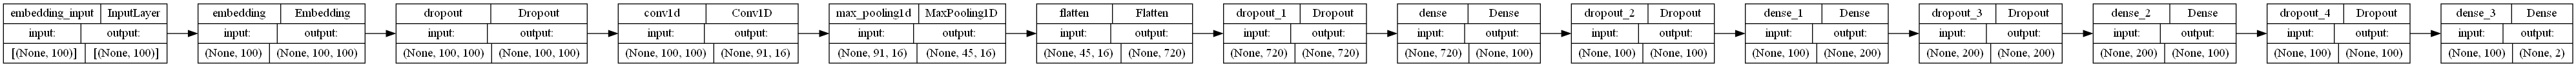

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_test.png', show_shapes=True, rankdir="LR")

In [33]:
import gensim
print(gensim.__version__)

4.2.0
